In [1]:
%%capture capt
!pip install scikit-learn-extra --upgrade
!pip install -U scikit-learn --upgrade

In [2]:
%%capture capt
import numpy as np
from sklearn.cluster import *
from sklearn.metrics import silhouette_score
from sklearn_extra.cluster import KMedoids
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
from time import time

# Useful functions

In [3]:
def display_time(start, stop):
    total = stop - start
    hours = total // 3600
    minutes = (total - 3600*hours) // 60
    seconds = int((total - 3600*hours) % 60)
    
    if hours > 0:
        print(f"Process took {hours}h, {minutes}min, {seconds}s to run")
    elif minutes > 0:
        print(f"Process took {minutes}min, {seconds}s to run")
    else:
        print(f"Process took {seconds}s to run")

# Importation data

In [4]:
base_patient = pd.read_csv("../data/profil_patient.csv")

In [5]:
%%capture capt
p_soins = pd.read_csv("../data/parcours_soins.csv")

# Data Pre-processing

In [6]:
base_patient.Mort = base_patient.Mort.astype(int)
base_patient.CHOC = base_patient.CHOC.astype(int)
base_patient.BEN_SEX_COD = base_patient.BEN_SEX_COD-1

In [7]:
# on ne conserve que l'annee de la premiere hospitalisation

base_patient.date_h0 = pd.to_datetime(base_patient.date_h0).apply(lambda date: int(date.year))

# Vecteur sur lequel appliquer le clustering

In [8]:
#items_to_keep = ["date_h0", "y_nais", "BEN_SEX_COD", "Mort", "Nb_survie", "Nb_hospit", "CHOC"]
items_to_keep = ["date_h0", "y_nais", "BEN_SEX_COD", "Nb_survie", "Nb_hospit"]

In [9]:
X_patient = base_patient[items_to_keep]

In [10]:
X_patient.head(3)

,date_h0,y_nais,BEN_SEX_COD,Nb_survie,Nb_hospit
0,2011,1949,0,2596,9
1,2013,1929,1,456,8
2,2015,1967,1,41,3


# K-Means/K-Medoids

In [11]:
import warnings
warnings.simplefilter("ignore")

In [12]:
def get_model(X, method, n_clusters, agglo_metric=None, agglo_link='ward', fit=True, show_fit=False):
 
    if method == 'kmeans':
        model = KMeans(n_clusters = n_clusters, n_init='auto')
    elif method == 'kmedoids':
        model = KMedoids(n_clusters=n_clusters, init='k-medoids++')
    elif method == 'kmedoids_precomputed':
        model = KMedoids(n_clusters=n_clusters, metric='precomputed', init='k-medoids++')
    elif method == 'bisecting_kmeans':
        model = BisectingKMeans(n_clusters=n_clusters, init='k-means++')
    elif method == 'agglomerative':
        model = AgglomerativeClustering(n_clusters=n_clusters, metric=agglo_metric,
                                    linkage=agglo_link)
    else:
        print("method was not in list.")
        print("Choose in ['kmeans', 'kmedoids', 'kmedoids_precomputed', 'bisecting_kmeans', 'agglomerative']")
        return

    if fit:
        print("The model is being fitted") if show_fit else None
        start = time()
        model.fit(X)
        stop = time()
        display_time(start, stop) if show_fit else None
    return model

In [13]:
def bic_score(X, labels):

    n_points = len(labels)
    n_clusters = len(set(labels))
    n_dimensions = np.shape(X)[1]

    n_parameters = (n_clusters - 1) + (n_dimensions * n_clusters) + 1

    loglikelihood = 0
    for label_name in set(labels):
        X_cluster = X[labels == label_name]
        n_points_cluster = len(X_cluster)
        centroid = np.mean(X_cluster, axis=0)
        variance = np.sum((X_cluster - centroid) ** 2) / (len(X_cluster) - 1)
        loglikelihood += \
          n_points_cluster * np.log(n_points_cluster) \
          - n_points_cluster * np.log(n_points) \
          - n_points_cluster * n_dimensions / 2 * np.log(2 * np.pi * variance) \
          - (n_points_cluster - 1) / 2

        bic = loglikelihood - (n_parameters / 2) * np.log(n_points)

    return bic

In [14]:
def calculate_scores(X, model):
    results = {}
    try:
        results["inertia"] = model.inertia_
    except:
        results["inertia"] = float('inf')
        #print(f"This model {model} has no inertia")
    
    try:
        results["silhouette"] = silhouette_score(X_patient, model.labels_)
    except:
        results["silhouette"] = float('inf')
    
    try:
        results["bic"] = bic_score(X_patient.values, model.labels_)
    except:
        results["bic"] = -float('inf')
    return results

In [15]:
%%capture capt
!pip install kneed[plot]

from kneed import KneeLocator

def find_elbow(inertia):
    k_elbow = KneeLocator(
      x=range(2, len(inertia)+2), 
      y=inertia, 
      curve="convex", 
      direction="decreasing").elbow
    return k_elbow

In [16]:
def calculate_scores_all_clusters(X, method, max_n_cluster = int(np.sqrt(len(X_patient))), agglo_metric=None, agglo_link='ward', show_fit=False):
    inertia = []
    bic = []
    silhouette = []
   
    for n_clusters in tqdm(range(2, max_n_cluster)):
        model = get_model(X, method, n_clusters, agglo_metric, agglo_link, fit=True, show_fit=show_fit)
        scores = calculate_scores(X, model)
        inertia.append(scores["inertia"])
        bic.append(scores["bic"])
        silhouette.append(scores["silhouette"])
                
    return inertia, bic, silhouette

In [17]:
def plot_scores(method, plots, names):
    
    for i, name in enumerate(names):
        if name == "inertia" or name == "inertie":
            elbow = find_elbow(plots[i])
            print(f"La méthode du coude --> nombre de clusters = {elbow} pour le modele {method}\n")
    
    fig, ax = plt.subplots(1, len(plots), figsize=(6*len(plots), 6))
    plt.suptitle(f"Plots for method {method}")
    for i, plot in enumerate(plots):
        ax[i].plot(range(2, len(plot)+2), plot, c = 'r', label = str(names[i]), marker='o')
        ax[i].legend(loc='best')
        ax[i].grid('on')
        ax[i].set_xlabel('Nombre de clusters')
        ax[i].set_ylabel('Score = ' + str(names[i]))
        
    plt.show()

In [18]:
def do_all(X, method, max_n_cluster = int(np.sqrt(len(X_patient))), agglo_metric=None, agglo_link='ward', show_fit=False):
    inertia, bic, silhouette = calculate_scores_all_clusters(X, method, max_n_cluster, agglo_metric, agglo_link, show_fit)
    
    plots, names = [], []
    if len(np.unique(inertia)) > 1:
        plots.append(inertia)
        names.append("inertia")
    if len(np.unique(bic)) > 1:
        plots.append(bic)
        names.append("bic")
    if len(np.unique(silhouette)) > 1:
        plots.append(silhouette)
        names.append("silhouette")
    
    plot_scores(method, plots, names)

100%|██████████| 98/98 [03:41<00:00,  2.26s/it]


La méthode du coude --> nombre de clusters = 9 pour le modele kmeans



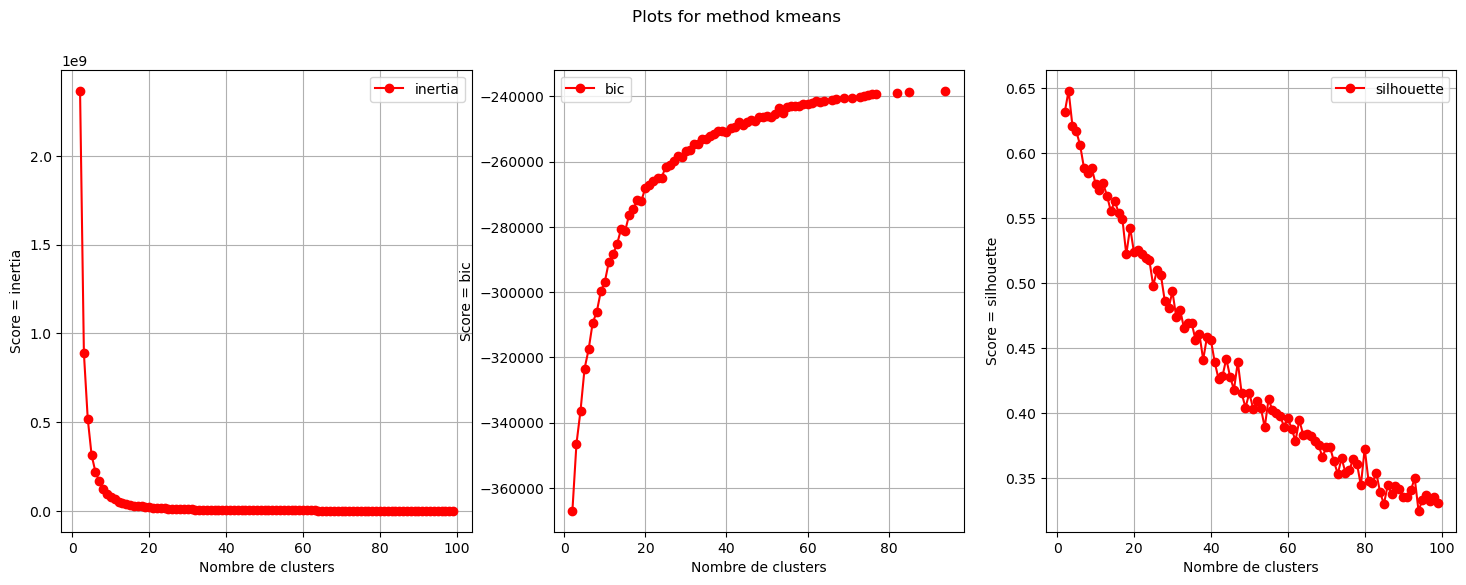

100%|██████████| 98/98 [09:07<00:00,  5.58s/it]


La méthode du coude --> nombre de clusters = 14 pour le modele kmedoids



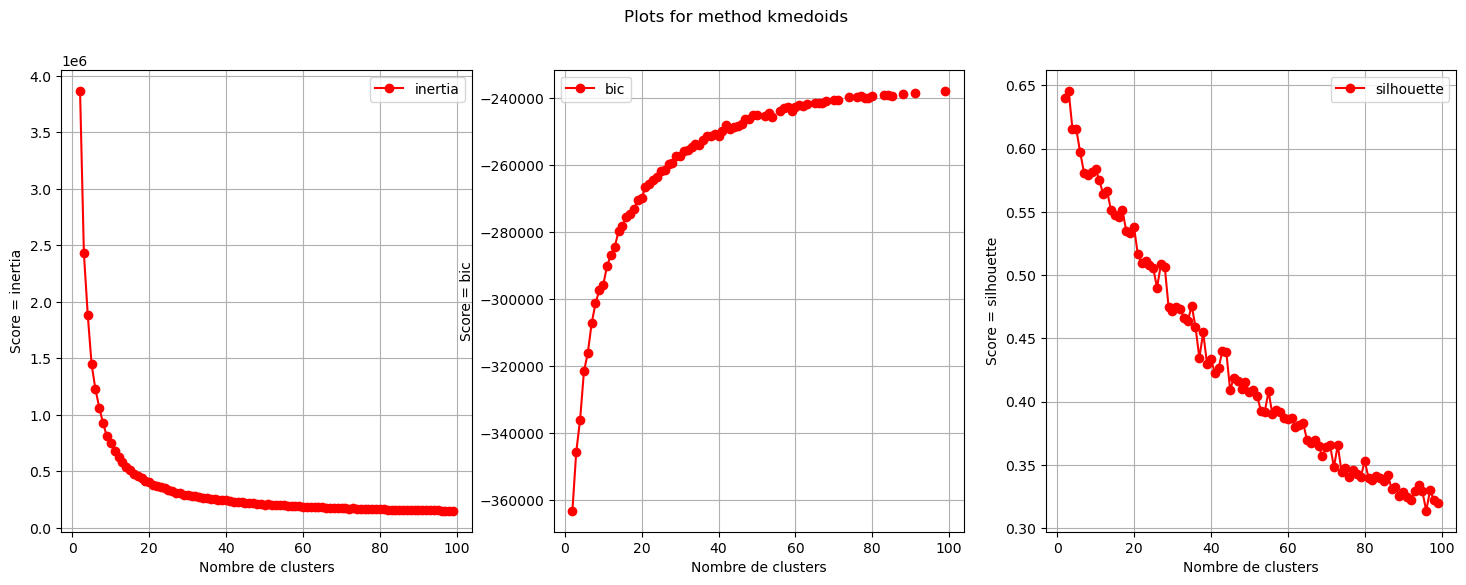

100%|██████████| 98/98 [06:48<00:00,  4.17s/it]


La méthode du coude --> nombre de clusters = 8 pour le modele bisecting_kmeans



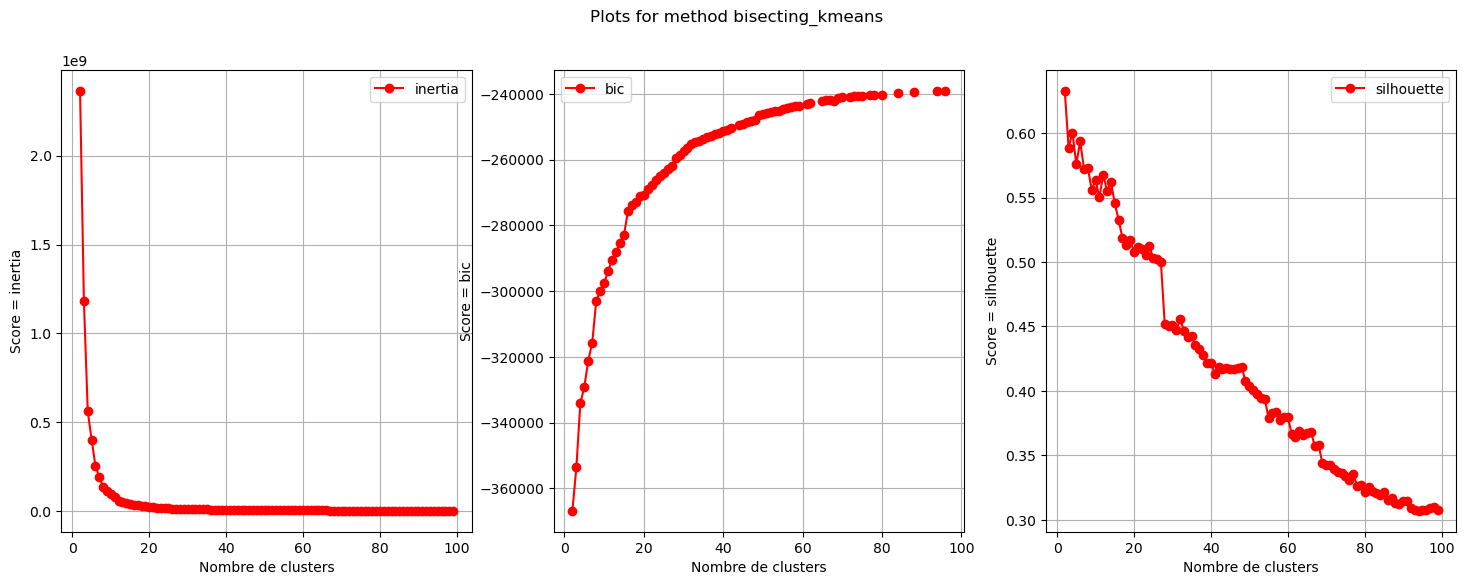

100%|██████████| 98/98 [08:50<00:00,  5.41s/it]


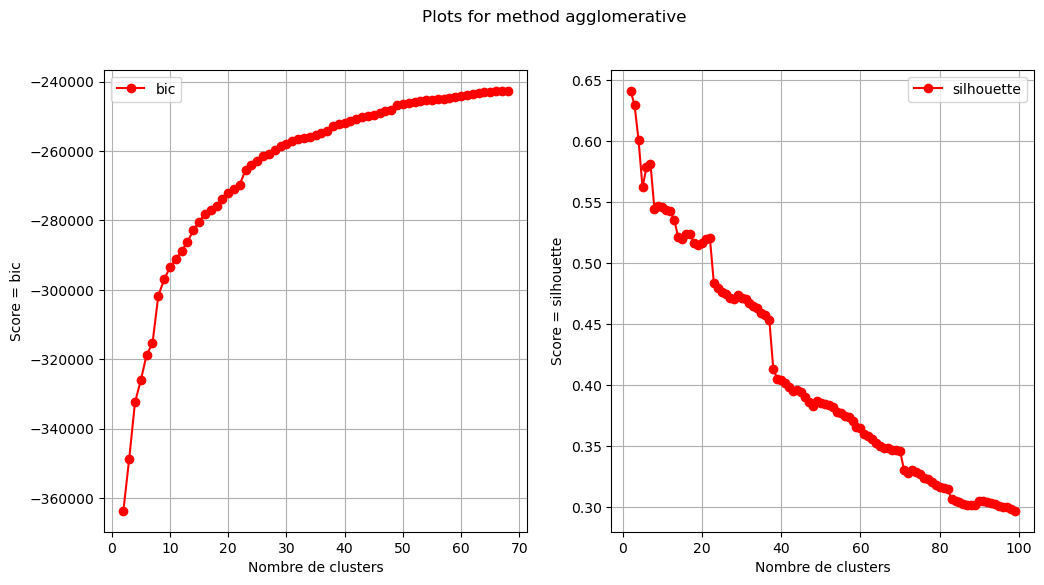

In [19]:
for method in ['kmeans', 'kmedoids', 'bisecting_kmeans', 'agglomerative']:
    do_all(X_patient, method)